In [2]:
#Load packages 
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import polars as pl
import pandas as pd
import seaborn as sns

#Load in files 
edges = pd.read_csv("edges.csv")
nodes = pd.read_csv("nodes.csv")

Index([' id', 'race', 'gender', 'sex.worker', 'pimp', 'sex.work.client',
       'drug.dealer', 'drug.cook', 'thief', 'retired', 'housewife', 'disabled',
       'unemployed', 'homeless', 'vocation'],
      dtype='object')
[1 0]
Baseline infection (no removal): 0.0818

Infection drops by group:
   sex worker    client     other  unemployed  drug dealer   retired  \
1   -0.075219  0.009325  0.001633    0.041448     0.028444 -0.007602   
0    0.026286  0.029740 -0.016155    0.000938    -0.029148  0.015461   

   disabled      pimp  housewife     thief  drug cook  homeless  
1  0.029397 -0.010121   0.038695 -0.007630   0.053752 -0.024555  
0 -0.006822  0.031524   0.002707  0.029637   0.004096  0.030122  


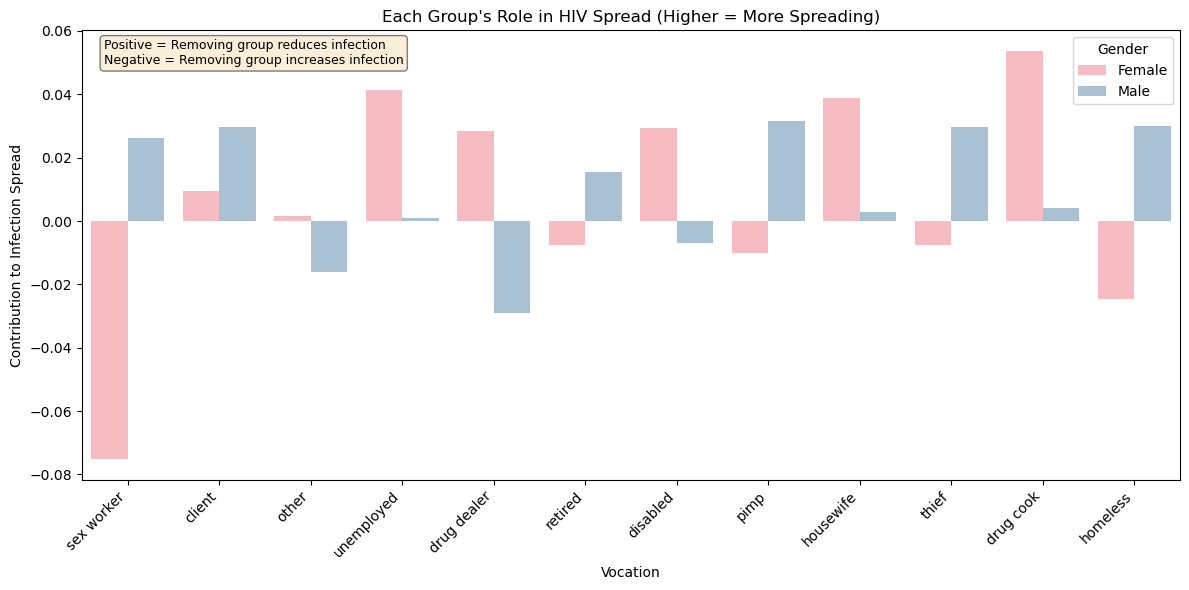

In [ ]:
#Bargraph not heatmap

# Baanee's Code
# Bar chart of infection results clustered by vocation and gender

# Step 1: Load Data 
print(nodes.columns)
print(nodes["gender"].unique())

#Random seed 
import random 
np.random.seed(42)
random.seed(42)

# Load edges, clean column names
edges = pl.read_csv("edges.csv").rename({c: c.strip() for c in pl.read_csv("edges.csv").columns})
edges = edges.to_pandas()

# Load nodes
nodes = pd.read_csv("nodes.csv")

# Step 2: Create a single categorical vocation column
def get_vocation(row):
    # Returns first true vocation in priority order
    if row["sex.worker"] == 1:
        return "sex worker"
    elif row["pimp"] == 1:
        return "pimp"
    elif row["sex.work.client"] == 1:
        return "client"
    elif row["drug.dealer"] == 1:
        return "drug dealer"
    elif row["drug.cook"] == 1:
        return "drug cook"
    elif row["thief"] == 1:
        return "thief"
    elif row["retired"] == 1:
        return "retired"
    elif row["housewife"] == 1:
        return "housewife"
    elif row["disabled"] == 1:
        return "disabled"
    elif row["unemployed"] == 1:
        return "unemployed"
    elif row["homeless"] == 1:
        return "homeless"
    else:
        return "other"

nodes["vocation"] = nodes.apply(get_vocation, axis=1)

# Step 3: Build Graph and load node attributes
G = nx.from_pandas_edgelist(edges, source="node1", target="node2")

# Assign attributes (note the space in " id")
for i, row in nodes.iterrows():
    node_id = row[" id"]
    if node_id in G.nodes:
        nx.set_node_attributes(G, {
            node_id: {
                "gender": row["gender"],
                "vocation": row["vocation"]
            }
        })

# Step 4: SI Infection Simulation (average infection over time)

def simulate_and_measure(G, beta=0.01, T=30):
    A = nx.to_numpy_array(G)
    n = len(G)

    I = np.zeros((T, n))
    patient_zero = np.random.randint(0, n)  # start from a random node
    I[0, patient_zero] = 1

    for t in range(1, T):
        prob = (A @ I[t-1]) * beta
        new_infected = (np.random.rand(n) < prob) | (I[t-1] == 1)
        I[t] = new_infected

    return I.mean(axis=1).mean()  # mean infection over time

# Step 5: Compute infection after removing each gender–vocation group

# IMPROVED SIMULATION FUNCTION 
def simulate_and_measure(G, beta=0.05, T=30, num_runs=10):
    if len(G) == 0:
        return 0
    
    infection_means = []
    for _ in range(num_runs):
        A = nx.to_numpy_array(G)
        n = len(G)
        I = np.zeros((T, n))
        patient_zero = np.random.randint(0, n)
        I[0, patient_zero] = 1
        
        for t in range(1, T):
            prob = (A @ I[t-1]) * beta
            new_infected = (np.random.rand(n) < prob) | (I[t-1] == 1)
            I[t] = new_infected
        
        infection_means.append(I.mean(axis=1).mean())
    
    return np.mean(infection_means)

# Calculate baseline infection first
baseline_infection = simulate_and_measure(G, beta=0.05, T=30, num_runs=10)
print(f"Baseline infection (no removal): {baseline_infection:.4f}")

# Now compute the DROP in infection when removing each group
genders = nodes["gender"].unique()
vocations = nodes["vocation"].unique()

results = []

for g in genders:
    row = []
    for v in vocations:
        removed_nodes = nodes[(nodes["gender"] == g) & (nodes["vocation"] == v)][" id"].tolist()
        
        # Skip if no nodes in this group
        if len(removed_nodes) == 0:
            row.append(0)
            continue
        
        G_sub = G.copy()
        G_sub.remove_nodes_from(removed_nodes)
        
        mean_infected = simulate_and_measure(G_sub, beta=0.05, T=30, num_runs=10)
        
        # Calculate the DROP from baseline (higher = more impact)
        infection_contribution = mean_infected - baseline_infection
        row.append(infection_contribution) 
    results.append(row)

# Create summary DataFrame
heatmap_data = pd.DataFrame(results, index=genders, columns=vocations)
print("\nInfection drops by group:")
print(heatmap_data)

# Step 6: Grouped Bar Chart (Male vs Female per vocation)
df_long = heatmap_data.reset_index().melt(
    id_vars="index",
    var_name="Vocation",
    value_name="Infection Drop"  # Changed label
)
df_long.rename(columns={"index": "Gender"}, inplace=True)
df_long["Gender"] = df_long["Gender"].map({0: "Male", 1: "Female"})

# Plot
plt.figure(figsize=(12,6))
sns.barplot(
    data=df_long,
    x="Vocation",
    y="Infection Drop",  # Changed label
    hue="Gender",
    palette={"Female": "#ffb3ba", "Male": "#a3c1da"}  # Light red and light blue
)

plt.xlabel("Vocation")
plt.ylabel("Contribution to Infection Spread")
plt.title("Each Group's Role in HIV Spread (Higher = More Spreading)") 
plt.xticks(rotation=45, ha="right")
plt.legend(title="Gender")
plt.tight_layout()
# Add text annotation
plt.text(0.02, 0.98, 
         "Positive = Removing group reduces infection\nNegative = Removing group increases infection",
         transform=plt.gca().transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
         fontsize=9)
plt.savefig("bargraph.png")
plt.show()



Number of components: 108
Sizes: [4430, 8, 3, 9, 9, 26, 8, 13, 23, 5, 42, 9, 17, 6, 4, 18, 6, 5, 50, 4, 20, 2, 7, 13, 2, 7, 12, 2, 18, 16, 4, 11, 8, 2, 4, 16, 2, 12, 3, 26, 3, 3, 8, 22, 7, 12, 12, 3, 4, 4, 7, 4, 12, 8, 4, 7, 16, 5, 17, 6, 5, 15, 8, 19, 19, 6, 3, 5, 5, 3, 2, 14, 2, 8, 13, 13, 13, 13, 8, 11, 4, 8, 8, 18, 12, 20, 11, 9, 3, 9, 5, 2, 17, 5, 3, 12, 15, 8, 9, 5, 2, 8, 9, 7, 9, 13, 4, 9]


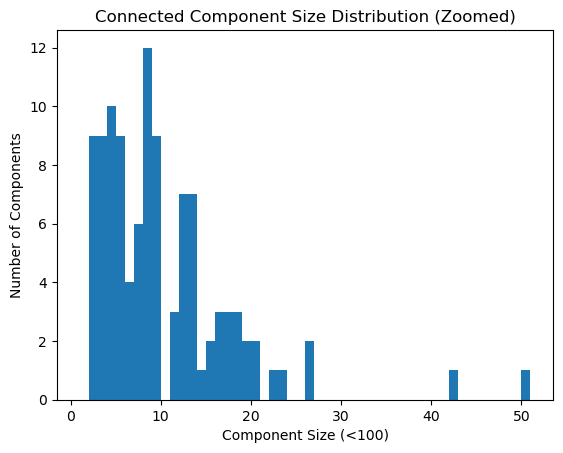

In [5]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import collections


# 1. Load your data

nodes = pd.read_csv("nodes.csv")
edges = pd.read_csv("edges.csv")

# 2. Fix the node ID column
# Colorado-90 uses " id" (with a space)
node_id_col = nodes.columns[0]   # first column is the ID (" id")
nodes[node_id_col] = nodes[node_id_col].astype(int)


# 3. Build the graph
# Use only the node IDs in edges

ucol = edges.columns[0]
vcol = edges.columns[1]

G = nx.from_pandas_edgelist(edges, source=ucol, target=vcol)

# 4. Compute connected component sizes

components = list(nx.connected_components(G))
component_sizes = [len(c) for c in components]

print("Number of components:", len(component_sizes))
print("Sizes:", component_sizes)

# 5. Plot the distribution

counts = collections.Counter(component_sizes)

small_components = [s for s in component_sizes if s < 100]

plt.hist(small_components, bins=range(1, max(small_components)+2))
plt.xlabel("Component Size (<100)")
plt.ylabel("Number of Components")
plt.title("Connected Component Size Distribution (Zoomed)")
plt.show()


This histogram shows how many connected HIV transmission clusters exist in the Colorado-90 dataset and how large they are. Each cluster (connected component) represents a group of people who are linked directly or indirectly through possible HIV transmission relationships. Most clusters are very small, often only a few individuals, which suggests many isolated cases or small groups with limited connections. A smaller number of medium-sized clusters appear, and only one or two large clusters exist. These large clusters likely correspond to the major transmission networks historically identified in the Colorado HIV-90 cohort, showing where most transmission occurred. Overall, this distribution reflects a highly fragmented network with a few major hubs of spread.

Nodes loaded: 5492
Edges loaded: 43288
Node columns: Index(['id', 'race', 'gender', 'sex.worker', 'pimp', 'sex.work.client',
       'drug.dealer', 'drug.cook', 'thief', 'retired', 'housewife', 'disabled',
       'unemployed', 'homeless'],
      dtype='object')

Demographic group sizes:
sex_workers 287
pimps 84
sex_work_clients 474
drug_dealers 350
drug_cooks 45
thieves 121
retired 160
housewives 331
disabled 226
unemployed 887
homeless 67


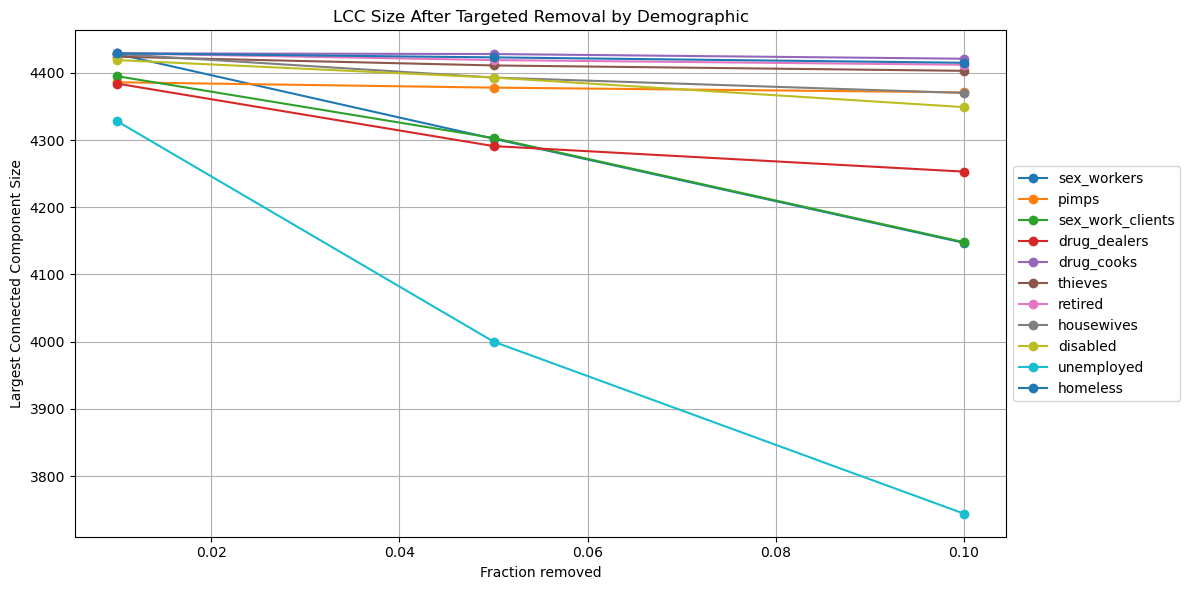

In [ ]:
#Import packages 
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

#Load Data 
nodes = pd.read_csv("nodes.csv")
edges = pd.read_csv("edges.csv")

# Fix error with id column
first_col = nodes.columns[0]
nodes = nodes.rename(columns={first_col: "id"})

print("Nodes loaded:", len(nodes))
print("Edges loaded:", len(edges))
print("Node columns:", nodes.columns)

# Build graph with nx function 
G = nx.from_pandas_edgelist(edges, source="node1", target="node2")


# 3. add node attributes 
attr_dict = nodes.set_index("id").to_dict(orient="index")
nx.set_node_attributes(G, attr_dict)


# 4. making demographic lists 
attribute_map = {
    "sex_workers": "sex.worker",
    "pimps": "pimp",
    "sex_work_clients": "sex.work.client",
    "drug_dealers": "drug.dealer",
    "drug_cooks": "drug.cook",
    "thieves": "thief",
    "retired": "retired",
    "housewives": "housewife",
    "disabled": "disabled",
    "unemployed": "unemployed",
    "homeless": "homeless"
}

def get_nodes_by_attribute(attr):
    return [n for n, data in G.nodes(data=True) if data.get(attr) == 1]

demographics = {group: get_nodes_by_attribute(attr)
                for group, attr in attribute_map.items()}

print("\nDemographic group sizes:")
for g, lst in demographics.items():
    print(g, len(lst))


# 5. compute LCC 
def compute_lcc_size(G):
    comps = list(nx.connected_components(G))
    return len(max(comps, key=len)) if len(comps) else 0

def lcc_after_removal(G, group_nodes, frac):
    G2 = G.copy()
    n_remove = max(1, int(len(group_nodes)*frac))
    high_deg = sorted(group_nodes, key=lambda x: G2.degree(x), reverse=True)
    G2.remove_nodes_from(high_deg[:n_remove])
    return compute_lcc_size(G2)


# 6. analysis of LCC 
fractions = [0.01, 0.05, 0.10]
lcc_results = {}

for group, nodes_list in demographics.items():
    lcc_results[group] = [lcc_after_removal(G, nodes_list, f) for f in fractions]


# 7. plot results 
plt.figure(figsize=(12,6))
for group, sizes in lcc_results.items():
    plt.plot(fractions, sizes, marker='o', label=group)

plt.xlabel("Fraction removed")
plt.ylabel("Largest Connected Component Size")
plt.title("LCC Size After Targeted Removal by Demographic")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()


In [15]:
for group, nodes_list in demographics.items():
    print("\n=== ", group, " ===")
    for f in fractions:
        G2 = G.copy()
        n_remove = max(1, int(len(nodes_list)*f))
        high_deg = sorted(nodes_list, key=lambda x: G2.degree(x), reverse=True)
        G2.remove_nodes_from(high_deg[:n_remove])

        sizes = component_size_distribution(G2)
        print(f"Fraction removed: {f}")
        print("  Largest:", sizes[0])
        print("  Num components:", len(sizes))
        print("  Mean size:", np.mean(sizes))
        print("  Median size:", np.median(sizes))



===  sex_workers  ===
Fraction removed: 0.01
  Largest: 4428
  Num components: 108
  Mean size: 50.675925925925924
  Median size: 8.0
Fraction removed: 0.05
  Largest: 4302
  Num components: 177
  Mean size: 30.853107344632768
  Median size: 4.0
Fraction removed: 0.1
  Largest: 4147
  Num components: 272
  Mean size: 20.02573529411765
  Median size: 1.0

===  pimps  ===
Fraction removed: 0.01
  Largest: 4386
  Num components: 151
  Mean size: 36.25165562913907
  Median size: 5.0
Fraction removed: 0.05
  Largest: 4378
  Num components: 156
  Mean size: 35.07051282051282
  Median size: 5.0
Fraction removed: 0.1
  Largest: 4371
  Num components: 159
  Mean size: 34.38364779874214
  Median size: 5.0

===  sex_work_clients  ===
Fraction removed: 0.01
  Largest: 4395
  Num components: 125
  Mean size: 43.768
  Median size: 7.0
Fraction removed: 0.05
  Largest: 4303
  Num components: 164
  Mean size: 33.24390243902439
  Median size: 5.0
Fraction removed: 0.1
  Largest: 4148
  Num components: